## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
import optuna
import time
import lightgbm as lgb
import os
from sklearn.metrics import root_mean_squared_error
from scipy.optimize import minimize as sp_minimize
from sklearn.preprocessing import StandardScaler
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

d:\Program Files\conda_envs\nitor_kuas\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configs

In [2]:
train_path = '../data/train.csv'
test_path = '../data/test_for_participants.csv'
sample_path = '../data/sample_submission.csv'
VAL_START = '2025-06-01'
SEED = 42
N_TRIALS_LGB = 30
SAVED_LGB_PATH = '../models/lgb_final.txt'
ROUND_MULTIPLIER = 1.15

os.makedirs('../models', exist_ok=True)

# Set random seed for reproducibility
np.random.seed(SEED)

## Data loading

In [3]:
train_raw = pd.read_csv(train_path)
test_raw = pd.read_csv(test_path)
sample_sub = pd.read_csv(sample_path)

In [4]:
for df in [train_raw, test_raw]:
    df['delivery_start'] = pd.to_datetime(df['delivery_start'])
    df['delivery_end'] = pd.to_datetime(df['delivery_end'])

train_raw['is_test'] = 0
test_raw['is_test'] = 1
test_raw['target'] = np.nan

df = pd.concat([train_raw, test_raw], ignore_index=True)
df = df.sort_values(['market', 'delivery_start']).reset_index(drop=True)
df.head()

,id,target,market,global_horizontal_irradiance,diffuse_horizontal_irradiance,direct_normal_irradiance,cloud_cover_total,cloud_cover_low,cloud_cover_mid,cloud_cover_high,...,wind_speed_80m,wind_direction_80m,wind_gust_speed_10m,wind_speed_10m,solar_forecast,wind_forecast,load_forecast,delivery_start,delivery_end,is_test
0,0,-1.913,Market A,0.0,0.0,0.0,2.0,0.0,0.0,2.0,...,31.253719,245.501450,25.199999,15.077082,0.0,24050.1,38163.0100,2023-01-01 00:00:00,2023-01-01 01:00:00,0
1,5,-0.839,Market A,0.0,0.0,0.0,15.0,0.0,0.0,15.0,...,30.918108,242.241547,23.400000,14.186923,0.0,23886.3,37379.1898,2023-01-01 01:00:00,2023-01-01 02:00:00,0
2,10,-1.107,Market A,0.0,0.0,0.0,17.0,0.0,0.0,17.0,...,26.983196,224.999893,21.240000,12.413477,0.0,23366.5,36336.8303,2023-01-01 02:00:00,2023-01-01 03:00:00,0
3,15,0.035,Market A,0.0,0.0,0.0,16.0,0.0,0.0,16.0,...,22.218153,229.600174,16.199999,10.483357,0.0,22829.8,35337.7595,2023-01-01 03:00:00,2023-01-01 04:00:00,0
4,20,-0.829,Market A,0.0,0.0,0.0,10.0,0.0,0.0,10.0,...,27.210381,244.113022,18.359999,11.918120,0.0,22347.6,34474.3403,2023-01-01 04:00:00,2023-01-01 05:00:00,0


## Enhanced Feature Engineering - Ultra Advanced Version

In [5]:
# Basic time features
ds = df["delivery_start"]
df["hour"]         = ds.dt.hour
df["day_of_week"]  = ds.dt.dayofweek
df["day_of_month"] = ds.dt.day
df["month"]        = ds.dt.month
df["quarter"]      = ds.dt.quarter
df["day_of_year"]  = ds.dt.dayofyear
df["year"]         = ds.dt.year
df["is_weekend"]   = (ds.dt.dayofweek >= 5).astype(np.int8)
df["week_of_year"] = ds.dt.isocalendar().week.astype(int)

# Cyclical encoding for time features
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

# Market encoding
market_map = {f"Market {c}": i for i, c in enumerate("ABCDEF")}
df["market_id"] = df["market"].map(market_map).astype(np.int8)

# Advanced demand and supply features
df["residual_demand"] = df["load_forecast"] - df["solar_forecast"] - df["wind_forecast"]
df["supply_ratio"] = (df["solar_forecast"] + df["wind_forecast"]) / (df["load_forecast"] + 1)
df["renewable_ratio"] = (df["solar_forecast"] + df["wind_forecast"]) / (df["solar_forecast"] + df["wind_forecast"] + df["load_forecast"] + 1)
df["net_supply"] = df["solar_forecast"] + df["wind_forecast"]
df["demand_supply_balance"] = df["load_forecast"] / (df["solar_forecast"] + df["wind_forecast"] + 1)

# Tightness ratios
df["tightness_ratio"] = df["residual_demand"] / (df["load_forecast"] + 1)
df["tightness_x_month"] = df["tightness_ratio"] * df["month"]
df["tightness_x_hour"] = df["tightness_ratio"] * df["hour"]
df["tightness_x_dow"] = df["tightness_ratio"] * df["day_of_week"]

# Price sensitivity indicators
df["solar_wind_ratio"] = df["solar_forecast"] / (df["wind_forecast"] + 1)
df["wind_solar_ratio"] = df["wind_forecast"] / (df["solar_forecast"] + 1)

In [6]:
# ── Advanced Weather Physics Features ──────────────────────────────────────
# First, alias columns whose names differ between dataset and our code

if 'convective_available_potential_energy' in df.columns:
    df['cape'] = df['convective_available_potential_energy']
if 'precipitation_amount' in df.columns:
    df['precipitation'] = df['precipitation_amount']
if 'apparent_temperature_2m' in df.columns:
    df['apparent_temperature'] = df['apparent_temperature_2m']
if 'freezing_level_height' in df.columns:
    df['boundary_layer_height'] = df['freezing_level_height']

# Estimate missing columns from available physics
# Saturation vapour pressure (Tetens formula)
es = 6.112 * np.exp((17.67 * df['air_temperature_2m']) / (df['air_temperature_2m'] + 243.5))
ea = (df['relative_humidity_2m'] / 100.0) * es
df['vapour_pressure_deficit_2m'] = es - ea

# Proxy precipitation probability from relative humidity
df['precipitation_probability'] = np.where(df['relative_humidity_2m'] > 85, 50, 0)

# ── Derived weather features ──
df['dew_point_depression']  = df['air_temperature_2m'] - df['dew_point_temperature_2m']
df['wet_bulb_depression']   = df['air_temperature_2m'] - df['wet_bulb_temperature_2m']
df['humidity_ratio']        = (0.622 * df['vapour_pressure_deficit_2m']) / (df['surface_pressure'] - df['vapour_pressure_deficit_2m'])
df['blh_normalized_pressure'] = df['boundary_layer_height'] / (df['surface_pressure'] / 1000)

# Wind shear (10m vs 80m)
df['wind_shear']       = df['wind_speed_80m'] - df['wind_speed_10m']
df['wind_shear_ratio'] = df['wind_speed_80m'] / (df['wind_speed_10m'] + 0.1)

# Convection indices
df['cape_cin_interaction'] = df['cape'] * df['convective_inhibition']
df['convection_potential'] = df['cape'] / (abs(df['convective_inhibition']) + 1)

# Visibility & cloud
df['visibility_cloud_interaction'] = df['visibility'] / (df['cloud_cover_total'] + 1)

# Combined weather severity index
df['weather_severity'] = (
    df['cloud_cover_total'] / 100 +
    (100 - df['visibility'].clip(0, 100)) / 100 +
    df['precipitation_probability'] / 100 +
    df['cape'] / 1000
) / 4

# Solar / wind potential
df['solar_potential'] = df['global_horizontal_irradiance'] * (1 - df['cloud_cover_total'] / 100)
df['wind_potential']  = df['wind_speed_80m'] ** 3  # cubic ∝ power

# Extreme weather flags
df['extreme_temp']   = ((df['air_temperature_2m'] > 30) | (df['air_temperature_2m'] < -5)).astype(int)
df['extreme_wind']   = (df['wind_speed_80m'] > 25).astype(int)
df['extreme_precip'] = (df['precipitation'] > 5).astype(int)

# Seasonal × weather interactions
df['temp_month_interaction'] = df['air_temperature_2m'] * df['month']
df['wind_month_interaction'] = df['wind_speed_80m'] * df['month']
df['solar_hour_interaction'] = df['solar_forecast'] * df['hour']

# Heating / cooling degree-hours
df['cooling_degree_hours'] = np.maximum(df['air_temperature_2m'] - 22, 0)
df['heating_degree_hours'] = np.maximum(18 - df['air_temperature_2m'], 0)

# Vapour pressure deficit normalised
df['vpd_normalized'] = df['vapour_pressure_deficit_2m'] / df['surface_pressure']

# Apparent temperature anomaly
df['apparent_temp_anomaly']   = df['apparent_temperature'] - df['air_temperature_2m']
df['apparent_air_temp_ratio'] = df['apparent_temperature'] / (df['air_temperature_2m'] + 1)

# Lifted Index feature (strong storm predictor)
if 'lifted_index' in df.columns:
    df['lifted_index_negative'] = (-df['lifted_index']).clip(lower=0)  # only instability

In [7]:
# ── Weather Momentum & Lag Features (NO target leakage) ────────────────────
weather_cols = ['wind_speed_80m', 'solar_forecast', 'load_forecast',
                'wind_forecast', 'air_temperature_2m']

for col in weather_cols:
    grp = df.groupby('market_id')[col]

    # Hourly differences (momentum)
    df[f'{col}_diff_1h']  = grp.diff(1)
    df[f'{col}_diff_3h']  = grp.diff(3)
    df[f'{col}_diff_6h']  = grp.diff(6)
    df[f'{col}_diff_12h'] = grp.diff(12)

    # Rolling mean / std
    df[f'{col}_rolling_mean_6h']  = grp.transform(lambda x: x.rolling(6,  min_periods=1).mean())
    df[f'{col}_rolling_std_6h']   = grp.transform(lambda x: x.rolling(6,  min_periods=1).std().fillna(0))
    df[f'{col}_rolling_mean_24h'] = grp.transform(lambda x: x.rolling(24, min_periods=1).mean())
    df[f'{col}_rolling_std_24h']  = grp.transform(lambda x: x.rolling(24, min_periods=1).std().fillna(0))

    # Rolling min / max (use bfill() instead of deprecated fillna(method=...))
    df[f'{col}_rolling_min_24h'] = grp.transform(lambda x: x.rolling(24, min_periods=1).min().bfill())
    df[f'{col}_rolling_max_24h'] = grp.transform(lambda x: x.rolling(24, min_periods=1).max().bfill())
    df[f'{col}_range_24h']       = df[f'{col}_rolling_max_24h'] - df[f'{col}_rolling_min_24h']

    # Exponential weighted moving averages
    df[f'{col}_ewm_6h']  = grp.transform(lambda x: x.ewm(span=6,  adjust=False).mean())
    df[f'{col}_ewm_24h'] = grp.transform(lambda x: x.ewm(span=24, adjust=False).mean())

    # Z-score vs rolling window
    df[f'{col}_zscore_24h'] = (df[col] - df[f'{col}_rolling_mean_24h']) / (df[f'{col}_rolling_std_24h'] + 0.001)

# Temperature anomaly vs recent history
df['temp_24h_mean']    = df.groupby('market_id')['air_temperature_2m'].transform(lambda x: x.rolling(24, min_periods=1).mean())
df['temp_72h_mean']    = df.groupby('market_id')['air_temperature_2m'].transform(lambda x: x.rolling(72, min_periods=1).mean())
df['temp_anomaly_24h'] = df['air_temperature_2m'] - df['temp_24h_mean']
df['temp_anomaly_72h'] = df['air_temperature_2m'] - df['temp_72h_mean']

# Wind direction components & stability
df['wind_dir_sin']    = np.sin(np.deg2rad(df['wind_direction_80m']))
df['wind_dir_cos']    = np.cos(np.deg2rad(df['wind_direction_80m']))
df['wind_dir_change'] = df.groupby('market_id')['wind_direction_80m'].diff(1).abs()

# Pressure & humidity interactions with temperature
df['pressure_temp_interaction']  = df['surface_pressure'] * df['air_temperature_2m']
df['humidity_temp_interaction']  = df['relative_humidity_2m'] * df['air_temperature_2m']
df['pressure_gradient']          = df.groupby('market_id')['surface_pressure'].diff(1)

# Cloud & precipitation transforms
df['cloud_cover_total_sq']  = df['cloud_cover_total'] ** 2
df['cloud_cover_effect']    = df['cloud_cover_total'] * df['global_horizontal_irradiance']
df['precip_prob_sq']        = df['precipitation_probability'] ** 2
df['precip_effect']         = df['precipitation'] * df['precipitation_probability']

# Radiation efficiency
df['solar_efficiency']       = df['solar_forecast'] / (df['global_horizontal_irradiance'] + 1)
df['radiation_cloud_ratio']  = df['global_horizontal_irradiance'] / (df['cloud_cover_total'] + 1)

In [8]:
# Advanced temporal features

# Hourly and daily patterns
df['hour_from_peak'] = abs(df['hour'] - 12)  # Distance from peak solar hour
df['is_peak_solar'] = ((df['hour'] >= 10) & (df['hour'] <= 16)).astype(int)
df['is_off_peak'] = ((df['hour'] >= 22) | (df['hour'] <= 6)).astype(int)
df['is_business_hours'] = ((df['hour'] >= 8) & (df['hour'] <= 18) & (df['day_of_week'] < 5)).astype(int)

# Week patterns
df['is_monday'] = (df['day_of_week'] == 0).astype(int)
df['is_friday'] = (df['day_of_week'] == 4).astype(int)
df['is_weekend_start'] = (df['day_of_week'] == 4).astype(int)  # Friday
df['is_weekend_end'] = (df['day_of_week'] == 6).astype(int)    # Sunday

# Monthly patterns
df['is_winter'] = df['month'].isin([12, 1, 2]).astype(int)
df['is_summer'] = df['month'].isin([6, 7, 8]).astype(int)
df['is_spring'] = df['month'].isin([3, 4, 5]).astype(int)
df['is_autumn'] = df['month'].isin([9, 10, 11]).astype(int)

# Quarter interactions
df['q1_temp_interaction'] = (df['quarter'] == 1) * df['air_temperature_2m']
df['q2_temp_interaction'] = (df['quarter'] == 2) * df['air_temperature_2m']
df['q3_temp_interaction'] = (df['quarter'] == 3) * df['air_temperature_2m']
df['q4_temp_interaction'] = (df['quarter'] == 4) * df['air_temperature_2m']

# Seasonal demand patterns
df['winter_load_factor'] = df['is_winter'] * df['load_forecast']
df['summer_load_factor'] = df['is_summer'] * df['load_forecast']
df['spring_load_factor'] = df['is_spring'] * df['load_forecast']
df['autumn_load_factor'] = df['is_autumn'] * df['load_forecast']

In [9]:
# ══════════════════════════════════════════════════════════════════════════════
# Historical Target Encoding  (FINAL SUBMISSION MODE — v5)
# ══════════════════════════════════════════════════════════════════════════════
# For final submission: compute group means from ALL observed data (Train + Val)
# so the test set benefits from the most complete historical signal.

# ⚠️ FINAL SUBMISSION MODE: using ALL observed data (train + val)
# For tuning/validation, change back to:
#     strict_train = df[(df['is_test'] == 0) & (df['delivery_start'] < VAL_START)]
strict_train = df[df['is_test'] == 0]  # ALL observed data

# ── Market × Hour mean ──
mean_mh = (strict_train
    .groupby(['market_id', 'hour'])['target']
    .mean().reset_index(name='target_histmean_mh'))

# ── Market × Day-of-week mean ──
mean_mdow = (strict_train
    .groupby(['market_id', 'day_of_week'])['target']
    .mean().reset_index(name='target_histmean_mdow'))

# ── Market × Month mean ──
mean_mm = (strict_train
    .groupby(['market_id', 'month'])['target']
    .mean().reset_index(name='target_histmean_mm'))

# ── Market mean (global baseline per market) ──
mean_m = (strict_train
    .groupby(['market_id'])['target']
    .mean().reset_index(name='target_histmean_m'))

# ── Hour mean (global baseline per hour) ──
mean_h = (strict_train
    .groupby(['hour'])['target']
    .mean().reset_index(name='target_histmean_h'))

# ── Market × Hour × DayOfWeek mean ──
mean_mhd = (strict_train
    .groupby(['market_id', 'hour', 'day_of_week'])['target']
    .mean().reset_index(name='target_histmean_mhd'))

# ── Market × Quarter mean ──
mean_mq = (strict_train
    .groupby(['market_id', 'quarter'])['target']
    .mean().reset_index(name='target_histmean_mq'))

# Merge ALL onto full dataframe
df = df.merge(mean_mh,  on=['market_id', 'hour'],          how='left')
df = df.merge(mean_mdow, on=['market_id', 'day_of_week'],  how='left')
df = df.merge(mean_mm,  on=['market_id', 'month'],          how='left')
df = df.merge(mean_m,   on=['market_id'],                   how='left')
df = df.merge(mean_h,   on=['hour'],                        how='left')
df = df.merge(mean_mhd, on=['market_id', 'hour', 'day_of_week'], how='left')
df = df.merge(mean_mq,  on=['market_id', 'quarter'],       how='left')

# Fill any NaN hist-means with global training mean
global_mean = strict_train['target'].mean()
for c in [c for c in df.columns if c.startswith('target_histmean_')]:
    df[c] = df[c].fillna(global_mean)

# ── Deviations from historical baselines (computed from safe features only) ──
df['histmean_mh_x_residual'] = df['target_histmean_mh'] * df['residual_demand']
df['histmean_mh_x_tightness'] = df['target_histmean_mh'] * df['tightness_ratio']
df['histmean_deviation_dow_vs_m'] = df['target_histmean_mdow'] - df['target_histmean_m']
df['histmean_deviation_mh_vs_h'] = df['target_histmean_mh'] - df['target_histmean_h']

print(f"✅ Safe historical encoding: {sum(c.startswith('target_histmean') for c in df.columns)} features")
print(f"   Global training mean: {global_mean:.4f}")

✅ Safe historical encoding: 7 features
   Global training mean: 33.9093


In [10]:
# ── Interaction features (weather × demand, cross-market) ──────────────────
df['temp_load_interaction']  = df['air_temperature_2m'] * df['load_forecast']
df['wind_load_interaction']  = df['wind_speed_80m'] * df['load_forecast']
df['solar_load_interaction'] = df['solar_forecast'] * df['load_forecast']
df['temp_wind_interaction']  = df['air_temperature_2m'] * df['wind_speed_80m']
df['temp_solar_interaction'] = df['air_temperature_2m'] * df['solar_forecast']
df['wind_solar_interaction'] = df['wind_speed_80m'] * df['solar_forecast']

# Triple interactions
df['temp_wind_load_interaction']  = df['air_temperature_2m'] * df['wind_speed_80m'] * df['load_forecast']
df['temp_solar_load_interaction'] = df['air_temperature_2m'] * df['solar_forecast'] * df['load_forecast']
df['wind_solar_load_interaction'] = df['wind_speed_80m'] * df['solar_forecast'] * df['load_forecast']

# Weather volatility (rolling on weather — safe, no target)
df['temp_volatility']  = df.groupby('market_id')['air_temperature_2m'].transform(lambda x: x.rolling(24, min_periods=1).std().fillna(0))
df['wind_volatility']  = df.groupby('market_id')['wind_speed_80m'].transform(lambda x: x.rolling(24, min_periods=1).std().fillna(0))
df['solar_volatility'] = df.groupby('market_id')['solar_forecast'].transform(lambda x: x.rolling(24, min_periods=1).std().fillna(0))

# Rate of change (weather — safe)
df['temp_rate_change']  = df.groupby('market_id')['air_temperature_2m'].diff(1) / (df.groupby('market_id')['air_temperature_2m'].shift(1).abs() + 0.01)
df['wind_rate_change']  = df.groupby('market_id')['wind_speed_80m'].diff(1) / (df.groupby('market_id')['wind_speed_80m'].shift(1).abs() + 0.01)
df['solar_rate_change'] = df.groupby('market_id')['solar_forecast'].diff(1) / (df.groupby('market_id')['solar_forecast'].shift(1).abs() + 0.01)

# Cross-market features (same timestamp, across markets — safe)
for col in ['wind_speed_80m', 'solar_forecast', 'load_forecast']:
    ts_mean = df.groupby('delivery_start')[col].transform('mean')
    ts_std  = df.groupby('delivery_start')[col].transform('std') + 0.001
    df[f'{col}_market_diff']   = df[col] - ts_mean
    df[f'{col}_market_zscore'] = (df[col] - ts_mean) / ts_std

# Advanced rolling statistics (weather — safe)
for col in ['wind_speed_80m', 'solar_forecast', 'load_forecast']:
    df[f'{col}_skew_24h'] = df.groupby('market_id')[col].transform(
        lambda x: x.rolling(24, min_periods=12).skew().fillna(0))


# ── SUMMER HEATWAVE & GRID STRESS ──────────────────────────────────────────────
# 1. Heatwave Penalty (Exponential stress when Temp > 25C and Wind is low)
df['heatwave_stress'] = np.where(
    (df['air_temperature_2m'] > 25) & (df['wind_speed_80m'] < 5),
    (df['air_temperature_2m'] - 25) ** 2, 
    0
)

# 2. Solar/Wind Drought Flag
df['renewable_drought'] = ((df['solar_forecast'] < 10) & (df['wind_forecast'] < 10)).astype(int)

# 3. Summer Cooling Load Proxy
df['cooling_degree_load'] = df['load_forecast'] * np.maximum(0, df['air_temperature_2m'] - 22)

# ── Final NaN handling ─────────────────────────────────────────────────────
# NEVER fill target NaN — those are test rows!
exclude_from_fill = {'target', 'delivery_start', 'delivery_end', 'market', 'id'}
for col in df.columns:
    if col in exclude_from_fill:
        continue
    if df[col].dtype in ['float64', 'float32', 'int64', 'int32', 'int8']:
        nan_count = df[col].isna().sum()
        if nan_count > 0:
            df[col] = df[col].fillna(df[col].median())

print(f"✅ Feature engineering complete: {len(df.columns)} total columns")
print(f"   Training rows: {(df['is_test']==0).sum()}, Test rows: {(df['is_test']==1).sum()}")
print(f"   NaN check (target): {df['target'].isna().sum()} NaN (should equal test rows)")

✅ Feature engineering complete: 235 total columns
   Training rows: 132608, Test rows: 13098
   NaN check (target): 13098 NaN (should equal test rows)


## Prepare X and y

In [11]:
observed_df = df[df['is_test'] == 0].copy()
test_df = df[df['is_test'] == 1].copy()

val_mask = observed_df['delivery_start'] >= VAL_START
train_df = observed_df[~val_mask]
val_df = observed_df[val_mask]

In [12]:
drop_cols = set(['id', 'target', 'market', 'delivery_start', 'delivery_end', 'is_test'])
feat_cols = sorted([c for c in df.columns if c not in drop_cols])
cat_idx = [feat_cols.index('market_id')] if 'market_id' in feat_cols else []

X_train = train_df[feat_cols]
y_train_real = train_df['target'].values
y_train = np.arcsinh(train_df['target'].values)

X_val = val_df[feat_cols]
y_val_real = val_df['target'].values
y_val = np.arcsinh(val_df['target'].values)

X_all = observed_df[feat_cols]
y_all_real = observed_df['target'].values
y_all = np.arcsinh(observed_df['target'].values)

X_test = test_df[feat_cols]

## Split-Train: Time-Decay Market 0 + Static Markets 1-5

In [13]:
# ══════════════════════════════════════════════════════════════════════════════
# SPLIT-TRAIN: TIME-DECAY WEIGHTED MARKET 0 + STATIC MARKETS 1-5
# ══════════════════════════════════════════════════════════════════════════════
# Strategy:
#   - Market 0:    Linear time-decay weights (0.1→1.0) to combat concept drift
#   - Markets 1-5: Static baseline (already elite at ~19-25 RMSE)
# ══════════════════════════════════════════════════════════════════════════════

import time
start_time = time.time()

# ── 1. Static Baseline Parameters (used for Markets 1-5) ─────────────────────
baseline_params = {
    "objective": "huber",
    "alpha": 1.5,
    "metric": "rmse",
    "verbosity": -1,
    "seed": SEED,
    "n_jobs": -1,
    "max_depth": 10,
    "num_leaves": 255,
    "learning_rate": 0.03,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1
}

# ── 2. Create Boolean Masks & Split Datasets ─────────────────────────────────
mask_train_m0   = X_train["market_id"] == 0
mask_train_rest = X_train["market_id"] > 0
mask_val_m0     = X_val["market_id"] == 0
mask_val_rest   = X_val["market_id"] > 0

X_train_m0   = X_train[mask_train_m0]
y_train_m0   = y_train[mask_train_m0.values]
X_train_rest = X_train[mask_train_rest]
y_train_rest = y_train[mask_train_rest.values]

X_val_m0       = X_val[mask_val_m0]
y_val_m0       = y_val[mask_val_m0.values]
y_val_real_m0  = y_val_real[mask_val_m0.values]
X_val_rest     = X_val[mask_val_rest]
y_val_rest     = y_val[mask_val_rest.values]
y_val_real_rest = y_val_real[mask_val_rest.values]

# Remove market_id from features for single-market model (it's constant=0)
feat_cols_m0 = [c for c in feat_cols if c != "market_id"]

print(f"Market 0    — Train: {len(X_train_m0):,}  |  Val: {len(X_val_m0):,}")
print(f"Markets 1-5 — Train: {len(X_train_rest):,}  |  Val: {len(X_val_rest):,}")
print()

# ══════════════════════════════════════════════════════════════════════════════
# PHASE 1: MARKET 0 — TIME-DECAY WEIGHTED TRAINING
# ══════════════════════════════════════════════════════════════════════════════
print("=" * 65)
print("🔷 TRAINING MODEL 0 (Market 0 — Time-Decay Weights)")
print("=" * 65)

# 1. Create Linear Time-Decay Weights (0.1 for oldest data, 1.0 for newest data)
# Since X_train_m0 is sorted chronologically, this smoothly increases the weight!
weights_m0 = np.linspace(0.1, 1.0, len(X_train_m0))
print(f"   Time-decay weights: {weights_m0[0]:.2f} (oldest) → {weights_m0[-1]:.2f} (newest)")

# 2. Market 0 specific params (slightly deeper to learn recent rules)
baseline_params_m0 = {
    "objective": "huber",
    "alpha": 1.5,
    "metric": "rmse",
    "verbosity": -1,
    "seed": SEED,
    "n_jobs": -1,
    "max_depth": 12,       # Slightly more depth to learn recent structural changes
    "num_leaves": 512,
    "learning_rate": 0.03,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1
}

# 3. Inject weights into the LightGBM Dataset
ds_train_m0 = lgb.Dataset(
    X_train_m0[feat_cols_m0], y_train_m0,
    weight=weights_m0,
    categorical_feature="auto", free_raw_data=False,
)
ds_val_m0 = lgb.Dataset(
    X_val_m0[feat_cols_m0], y_val_m0,
    reference=ds_train_m0, free_raw_data=False,
)

# 4. Train with early stopping
evals_result_m0 = {}
model_m0 = lgb.train(
    baseline_params_m0,
    ds_train_m0,
    num_boost_round=4000,
    valid_sets=[ds_train_m0, ds_val_m0],
    valid_names=["train", "val"],
    callbacks=[
        lgb.early_stopping(150, verbose=False),
        lgb.log_evaluation(200),
        lgb.record_evaluation(evals_result_m0),
    ],
)

# Evaluate Model 0
val_preds_m0_raw  = model_m0.predict(X_val_m0[feat_cols_m0])
val_preds_m0_real = np.sinh(val_preds_m0_raw)
rmse_m0 = root_mean_squared_error(y_val_real_m0, val_preds_m0_real)

train_preds_m0_real = np.sinh(model_m0.predict(X_train_m0[feat_cols_m0]))
train_rmse_m0 = root_mean_squared_error(
    train_df.loc[mask_train_m0, "target"].values, train_preds_m0_real
)

print(f"\n🔷 Model 0 — Val RMSE: {rmse_m0:.4f}  |  Train RMSE: {train_rmse_m0:.4f}  |  Iters: {model_m0.best_iteration}")

# ══════════════════════════════════════════════════════════════════════════════
# PHASE 2: STATIC MODEL REST (Markets 1-5) — UNCHANGED
# ══════════════════════════════════════════════════════════════════════════════
print("\n" + "=" * 65)
print("🟢 TRAINING MODEL REST — STATIC BASELINE (Markets 1-5)")
print("=" * 65)

ds_train_rest = lgb.Dataset(
    X_train_rest, y_train_rest,
    categorical_feature=cat_idx if cat_idx else "auto",
    free_raw_data=False,
)
ds_val_rest = lgb.Dataset(
    X_val_rest, y_val_rest,
    reference=ds_train_rest, free_raw_data=False,
)

evals_result_rest = {}
model_rest = lgb.train(
    baseline_params,
    ds_train_rest,
    num_boost_round=3000,
    valid_sets=[ds_train_rest, ds_val_rest],
    valid_names=["train", "val"],
    callbacks=[
        lgb.early_stopping(100, verbose=False),
        lgb.log_evaluation(200),
        lgb.record_evaluation(evals_result_rest),
    ],
)

# Evaluate Model Rest
val_preds_rest_raw  = model_rest.predict(X_val_rest)
val_preds_rest_real = np.sinh(val_preds_rest_raw)
rmse_rest = root_mean_squared_error(y_val_real_rest, val_preds_rest_real)

train_preds_rest_real = np.sinh(model_rest.predict(X_train_rest))
train_rmse_rest = root_mean_squared_error(
    train_df.loc[mask_train_rest, "target"].values, train_preds_rest_real
)

print(f"\n🟢 Model Rest — Val RMSE: {rmse_rest:.4f}  |  Train RMSE: {train_rmse_rest:.4f}  |  Iters: {model_rest.best_iteration}")

# ══════════════════════════════════════════════════════════════════════════════
# PHASE 3: COMBINED EVALUATION
# ══════════════════════════════════════════════════════════════════════════════
val_preds_combined = np.empty(len(y_val_real))
val_preds_combined[mask_val_m0.values]   = val_preds_m0_real
val_preds_combined[mask_val_rest.values] = val_preds_rest_real

combined_rmse = root_mean_squared_error(y_val_real, val_preds_combined)
elapsed = time.time() - start_time

print("\n" + "=" * 65)
print("📊 SPLIT-TRAIN RESULTS (Time-Decay M0 + Static M1-5)")
print("=" * 65)
print(f"  🔷 Market 0    Val RMSE:  {rmse_m0:.4f}   (time-decay weighted, {model_m0.best_iteration} iters)")
print(f"  🟢 Markets 1-5 Val RMSE:  {rmse_rest:.4f}   (static baseline, {model_rest.best_iteration} iters)")
print(f"  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
print(f"  ✅ COMBINED Val RMSE:      {combined_rmse:.4f}")
print(f"  ⏱ Total time: {elapsed:.0f}s")
print("=" * 65)

Market 0    — Train: 21,165  |  Val: 2,208
Markets 1-5 — Train: 98,195  |  Val: 11,040

🔷 TRAINING MODEL 0 (Market 0 — Time-Decay Weights)
   Time-decay weights: 0.10 (oldest) → 1.00 (newest)
[200]	train's rmse: 0.835584	val's rmse: 1.91757
[400]	train's rmse: 0.627451	val's rmse: 1.90038
[600]	train's rmse: 0.500567	val's rmse: 1.89764
[800]	train's rmse: 0.410833	val's rmse: 1.89537

🔷 Model 0 — Val RMSE: 86.9871  |  Train RMSE: 65.7812  |  Iters: 732

🟢 TRAINING MODEL REST — STATIC BASELINE (Markets 1-5)
[200]	train's rmse: 1.18442	val's rmse: 1.24859

🟢 Model Rest — Val RMSE: 24.7181  |  Train RMSE: 99.9184  |  Iters: 220

📊 SPLIT-TRAIN RESULTS (Time-Decay M0 + Static M1-5)
  🔷 Market 0    Val RMSE:  86.9871   (time-decay weighted, 732 iters)
  🟢 Markets 1-5 Val RMSE:  24.7181   (static baseline, 220 iters)
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  ✅ COMBINED Val RMSE:      42.0747
  ⏱ Total time: 37s


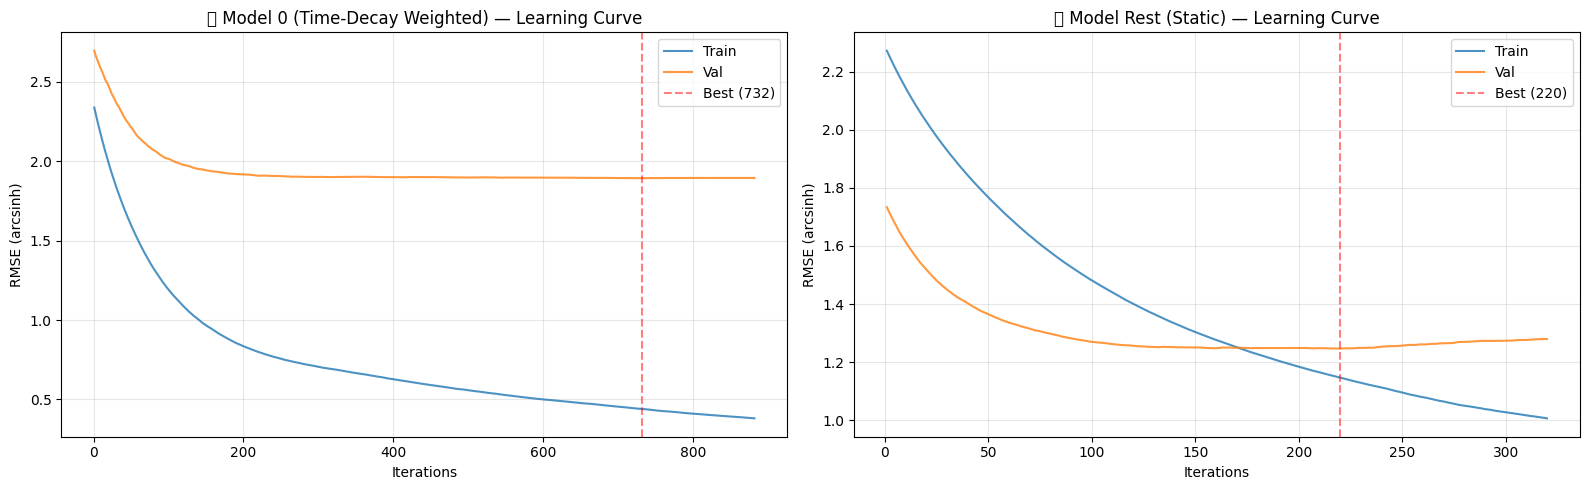


🏭 RMSE BY MARKET (VALIDATION SET)
  🔷 M0 (Time-Decay) | Market 0 | Rows: 2208 | RMSE: 86.9871
  🟢 MR (Static) | Market 1 | Rows: 2208 | RMSE: 25.8592
  🟢 MR (Static) | Market 2 | Rows: 2208 | RMSE: 24.5209
  🟢 MR (Static) | Market 3 | Rows: 2208 | RMSE: 25.4944
  🟢 MR (Static) | Market 4 | Rows: 2208 | RMSE: 27.0359
  🟢 MR (Static) | Market 5 | Rows: 2208 | RMSE: 20.1006

📅 RMSE BY MONTH (VALIDATION SET)
  Month 06 | Rows: 4320 | RMSE: 29.1949
  Month 07 | Rows: 4464 | RMSE: 44.4542
  Month 08 | Rows: 4464 | RMSE: 49.5248

🔷 Top-10 Features — Model 0 (Time-Decay Weighted)
    demand_supply_balance: 62369
    renewable_ratio: 53981
    tightness_ratio: 28574
    year: 16897
    supply_ratio: 15137
    net_supply: 14835
    wind_speed_10m: 10326
    wind_solar_load_interaction: 10256
    wind_solar_interaction: 8780
    day_of_year: 5164

🟢 Top-10 Features — Model Rest (Static)
    tightness_ratio: 358099
    wind_potential: 286768
    demand_supply_balance: 162183
    renewable_ratio: 

In [14]:
# ── Learning Curves (Both Models Side-by-Side) ───────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# LEFT: Model 0 learning curve (time-decay weighted)
tr_curve_m0 = evals_result_m0["train"]["rmse"]
vl_curve_m0 = evals_result_m0["val"]["rmse"]
axes[0].plot(range(1, len(tr_curve_m0)+1), tr_curve_m0, label="Train", alpha=0.8, lw=1.5)
axes[0].plot(range(1, len(vl_curve_m0)+1), vl_curve_m0, label="Val",   alpha=0.8, lw=1.5)
axes[0].axvline(x=model_m0.best_iteration, color="red", ls="--", alpha=0.5, label=f"Best ({model_m0.best_iteration})")
axes[0].set_xlabel("Iterations"); axes[0].set_ylabel("RMSE (arcsinh)")
axes[0].set_title("🔷 Model 0 (Time-Decay Weighted) — Learning Curve")
axes[0].legend(); axes[0].grid(True, alpha=0.3)

# RIGHT: Model Rest learning curve (static)
tr_curve_rest = evals_result_rest["train"]["rmse"]
vl_curve_rest = evals_result_rest["val"]["rmse"]
axes[1].plot(range(1, len(tr_curve_rest)+1), tr_curve_rest, label="Train", alpha=0.8, lw=1.5)
axes[1].plot(range(1, len(vl_curve_rest)+1), vl_curve_rest, label="Val",   alpha=0.8, lw=1.5)
axes[1].axvline(x=model_rest.best_iteration, color="red", ls="--", alpha=0.5, label=f"Best ({model_rest.best_iteration})")
axes[1].set_xlabel("Iterations"); axes[1].set_ylabel("RMSE (arcsinh)")
axes[1].set_title("🟢 Model Rest (Static) — Learning Curve")
axes[1].legend(); axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ── Per-Market RMSE Breakdown ────────────────────────────────────────────────
val_results = val_df[["delivery_start", "market_id"]].copy()
val_results["actual"] = y_val_real
val_results["predicted"] = val_preds_combined

print("\n" + "=" * 65)
print("🏭 RMSE BY MARKET (VALIDATION SET)")
print("=" * 65)

for mkt in sorted(val_results["market_id"].unique()):
    mkt_data = val_results[val_results["market_id"] == mkt]
    mkt_rmse = root_mean_squared_error(mkt_data["actual"], mkt_data["predicted"])
    model_tag = "🔷 M0 (Time-Decay)" if mkt == 0 else "🟢 MR (Static)"
    print(f"  {model_tag} | Market {mkt} | Rows: {len(mkt_data):4d} | RMSE: {mkt_rmse:.4f}")

print("=" * 65)

# ── Monthly RMSE Breakdown ───────────────────────────────────────────────────
val_results["month"] = val_results["delivery_start"].dt.month

print("\n" + "=" * 65)
print("📅 RMSE BY MONTH (VALIDATION SET)")
print("=" * 65)

for m in sorted(val_results["month"].unique()):
    month_data = val_results[val_results["month"] == m]
    month_rmse = root_mean_squared_error(month_data["actual"], month_data["predicted"])
    print(f"  Month {m:02d} | Rows: {len(month_data):4d} | RMSE: {month_rmse:.4f}")

print("=" * 65)

# ── Top-10 Feature Importance (both models) ──────────────────────────────────
print("\n" + "=" * 65)
print("🔷 Top-10 Features — Model 0 (Time-Decay Weighted)")
print("=" * 65)
imp_m0 = pd.Series(model_m0.feature_importance("gain"), index=feat_cols_m0)
for f, v in imp_m0.nlargest(10).items():
    print(f"    {f}: {v:.0f}")

print("\n" + "=" * 65)
print("🟢 Top-10 Features — Model Rest (Static)")
print("=" * 65)
imp_rest = pd.Series(model_rest.feature_importance("gain"), index=feat_cols)
for f, v in imp_rest.nlargest(10).items():
    print(f"    {f}: {v:.0f}")

## Final Retrain & Test Predictions

In [15]:
# ══════════════════════════════════════════════════════════════════════════════
# GENERATE TEST PREDICTIONS (Time-Decay M0 + Static Rest)
# ══════════════════════════════════════════════════════════════════════════════

# Retrain on ALL observed data (train+val) for final submission
print("Retraining on full observed data for submission...")

mask_all_m0   = X_all["market_id"] == 0
mask_all_rest = X_all["market_id"] > 0

# Model 0 final — time-decay weights on FULL observed Market 0 data
X_all_m0 = X_all[mask_all_m0]
y_all_m0 = y_all[mask_all_m0.values]
weights_all_m0 = np.linspace(0.1, 1.0, len(X_all_m0))

ds_all_m0 = lgb.Dataset(
    X_all_m0[feat_cols_m0], y_all_m0,
    weight=weights_all_m0,
    categorical_feature="auto", free_raw_data=False,
)
model_m0_final = lgb.train(
    baseline_params_m0, ds_all_m0,
    num_boost_round=int(model_m0.best_iteration * 1.1),
)

# Model Rest final — use STATIC baseline params (no weights)
ds_all_rest = lgb.Dataset(
    X_all[mask_all_rest], y_all[mask_all_rest.values],
    categorical_feature=cat_idx if cat_idx else "auto", free_raw_data=False,
)
model_rest_final = lgb.train(
    baseline_params, ds_all_rest,
    num_boost_round=int(model_rest.best_iteration * 1.1),
)

# Predict on test set
mask_test_m0   = X_test["market_id"] == 0
mask_test_rest = X_test["market_id"] > 0

lgb_test_preds = np.empty(len(X_test))
lgb_test_preds[mask_test_m0.values]   = np.sinh(model_m0_final.predict(X_test[mask_test_m0][feat_cols_m0]))
lgb_test_preds[mask_test_rest.values] = np.sinh(model_rest_final.predict(X_test[mask_test_rest]))

print(f"✅ Test predictions generated: {len(lgb_test_preds):,} rows")
print(f"   Market 0 test rows:    {mask_test_m0.sum():,}  (time-decay weighted)")
print(f"   Markets 1-5 test rows: {mask_test_rest.sum():,}  (static baseline)")

Retraining on full observed data for submission...
✅ Test predictions generated: 13,098 rows
   Market 0 test rows:    2,183  (time-decay weighted)
   Markets 1-5 test rows: 10,915  (static baseline)


## Create Submission File

In [16]:
# ══════════════════════════════════════════════════════════════════════════════
# CREATE SUBMISSION FILE
# ══════════════════════════════════════════════════════════════════════════════

# Build prediction DataFrame keyed by id (our test_df is sorted by market/time,
# but sample_submission has a different id order — we must match it exactly)
pred_df = pd.DataFrame({
    "id": test_df["id"].values,
    "target": lgb_test_preds
})

# Merge onto sample_sub to guarantee identical id order
submission = sample_sub[["id"]].merge(pred_df, on="id", how="left")

# Sanity checks
assert len(submission) == len(sample_sub), f"Row mismatch: {len(submission)} vs {len(sample_sub)}"
assert submission["target"].isna().sum() == 0, f"Missing predictions for {submission['target'].isna().sum()} ids!"
assert (submission["id"] == sample_sub["id"]).all(), "ID order mismatch!"

# Save
submission_path = "../submissions/submission_split_timedecay.csv"
import os
os.makedirs("../submissions", exist_ok=True)
submission.to_csv(submission_path, index=False)

print(f"✅ Submission saved: {submission_path}")
print(f"   Rows: {len(submission):,}")
print(f"   ID order matches sample_submission: ✓")
print(f"   Target stats:")
print(f"     Mean:   {submission['target'].mean():.4f}")
print(f"     Std:    {submission['target'].std():.4f}")
print(f"     Min:    {submission['target'].min():.4f}")
print(f"     Max:    {submission['target'].max():.4f}")
print(f"     Median: {submission['target'].median():.4f}")

✅ Submission saved: ../submissions/submission_split_timedecay.csv
   Rows: 13,098
   ID order matches sample_submission: ✓
   Target stats:
     Mean:   23.7141
     Std:    21.6534
     Min:    -85.2638
     Max:    223.5979
     Median: 21.3969
